# AR(1) + GARCH(1,1) Model

## Loading Packages

In [1]:
using Optim, ForwardDiff

using Compat, Missings        #in Julia 0.6 
#using Dates, DelimitedFiles  #in Julia 0.7

include("jlFiles/printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots

backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

## Loading Data

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
ymd = round.(Int,xx[:,1])     #YearMonthDay, like 20121231
R   = xx[:,2]                 #returns for the smallest size portfolio
xx  = nothing

y = R[2:end]                           #dependent variable, y(t)
x = [ones(size(R,1)-1) R[1:end-1]]     #regressors, [1, y(t-1)]

dN = Date.(string.(ymd),"yyyymmdd")
println("The first four dates:")
printmat(dN[1:4])

The first four dates:
1980-01-02
1980-01-03
1980-01-04
1980-01-07



## The Likelihood Function

Consider a regression equation, where the residual follows a GARCH(1,1) process

$
y_{t}             =x_{t}^{\prime}b+u_{t} \: \text{ with }\: u_{t}=v_{t}\sigma_{t} \: \text{ and }
$

$
\sigma_{t}^{2}    =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.
$

Notice that we require $(\omega,\alpha,\beta)$ to all be positive and $\alpha + \beta < 1$.

If $v_{t}\sim N(0,1)$, then the likelihood function is

$
\ln L=-\frac{T}{2}\ln(2\pi)  
-\frac{1}{2}\sum_{t=1}^{T}\ln\sigma_{t}^{2}-
\frac{1}{2}\sum_{t=1}^{T}\frac{u_{t}^{2}}{\sigma_{t}
^{2}}.
$

The likelihood function of a GARCH(1,1) model can be coded as in
*garch11LL*. The first function calculates time-varying  variances and
the likelihood contributions (for each period). The second functions forms the
loss function used in the minimization.

In [4]:
function garch11LL(par::Vector,y,x)

  (T,k) = (size(x,1),size(x,2))

  b                   = par[1:k]             #mean equation, y = x'*b
  (omega,alpha,beta1) = par[k+1:k+3]         #GARCH(1,1) equation: 
                                             #s2(t) = omega + alpha*u(t-1)^2 + beta1*s2(t-1)        
  yhat = x*b
  u    = y - yhat
  s2_0 = var(u)                                 #var(u,1) gives a matrix, var(u) a scalar

  s2    = zeros(typeof(alpha),T)                 #works also with ForwardDiff 
  s2[1] = omega + alpha*s2_0 + beta1*s2_0        #simple, but slow approach
  for t = 2:T                                    #using filter() is perhaps quicker
    s2[t] = omega + alpha*u[t-1]^2 + beta1*s2[t-1]
  end

  LL    = -(1/2)*log(2*pi) .- (1/2)*log.(s2) .- (1/2)*(u.^2)./s2
  LL[1] = 0.0               #effectively skip the first observation

  return LL,s2,yhat

end


function garch11LLLoss(par::Vector,y,x)         #loss fn to minimize
    par1            = copy(par)
    par1[end-2:end] = abs.(par1[end-2:end])     #impose non-negativity on (omega,alpha,beta)
    LL,  = garch11LL(par1,y,x)
    Loss = -sum(LL)                             #to minimize: -sum(LL)
    return Loss
end


function garch11LLRLoss(par::Vector,y,x,rho)     #loss fn, with penalty on alpha+beta1 > 1
    par1            = copy(par)
    par1[end-2:end] = abs.(par1[end-2:end])      #impose non-negativity
    LL, = garch11LL(par1,y,x)
    (alpha,beta1) = par1[end-1:end]   #s2(t) = omega + alpha*u(t-1)^2 + beta1*s2(t-1)
    g = [alpha + beta1 - 1]                     #alpha + beta1 < 1
    Loss = -sum(LL) + rho*sum(max.(0,g).^2)
    return Loss
end

garch11LLRLoss (generic function with 1 method)

## Try the Likelihood Function

In [5]:
par0 = [mean(y),0,var(y)*0.05,0.05,0.93]         #initial parameter guess

(loglik,s2,yhat) = garch11LL(par0,y,x)            #just testing the log lik
LL               = garch11LLLoss(par0,y,x)

printlnPs("Value of log-likelihood fn at starting guess: ",-LL)

Value of log-likelihood fn at starting guess:  -9846.688


## Maximize the Likelihood Function

In [6]:
Sol = optimize(par->garch11LLLoss(par,y,x),par0)   #minimize -sum(LL)

parHat            = Optim.minimizer(Sol)          #extract the optimal solution 
parHat[end-2:end] = abs.(parHat[end-2:end])       #since the likelihood function uses abs(these values)

LLHat             = garch11LLLoss(parHat,y,x)
printlnPs("Value of log-likelihood fn at estimate: ",-LLHat)

println("\nParameter estimates (b[1],b[2],omega,alpha,beta1): ")
printmat(parHat)

Value of log-likelihood fn at estimate:  -8243.608

Parameter estimates (b[1],b[2],omega,alpha,beta1): 
     0.049
     0.256
     0.014
     0.162
     0.824



## Standard Errors of the Estimates

MLE is typically asymptotically normally distributed

$
\sqrt{T}(\hat{\theta}-\theta)  \rightarrow^{d}N(0,V) \: \text{, where } \: V=I(\theta)^{-1}\text{ with }
$

$
I(\theta) =-\text{E}\frac{\partial^{2}\ln L_t}{\partial\theta\partial\theta^{\prime}}
$

where $\ln L_t$  is the contribution of period $t$ to the likelihood function and $I(\theta)$ is the information matrix.

The code below calculates numerical derivatives.  


Alternatively, we can use the outer product of the gradients to calculate the
information matrix as

$
J(\theta)=\text{E}\left[  \frac{\partial\ln L_t}{\partial\theta
}\frac{\partial\ln L_t}{\partial\theta^{\prime}}\right]
$

We could also use the "sandwich" estimator

$
V=I(\theta)^{-1}J(\theta)I(\theta)^{-1}.
$

### Std from Hessian

In [7]:
T = size(y,1)                    #finding std(coefs) by inverse of information matrix

Ia         = -ForwardDiff.hessian(par->mean(garch11LL(par,y,x)[1]),parHat)
Ia         = (Ia+Ia')/2              #to guarantee symmetry
vcv        = inv(Ia)/T
std_parHat = sqrt.(diag(vcv))

println("std from Hessian")
printmat(std_parHat)

std from Hessian
     0.006
     0.012
     0.001
     0.009
     0.009



### Std from Gradient and Sandwich

In [8]:
LLgrad = ForwardDiff.jacobian(par->garch11LL(par,y,x)[1],parHat)   #T x length(par) matrix, T gradients
J           = LLgrad'LLgrad/T
vcv         = inv(J)/T
stdb_parHat = sqrt.(diag(vcv))                          #std from gradients

vcv         = inv(Ia) * J * inv(Ia)/T
stdc_parHat = sqrt.(diag(vcv))                          #std from sandwich

printlnPs("\nGARCH parameter estimates and 3 different standard errors
    coef     hessian     gradient  sandwich")
printmat([parHat std_parHat stdb_parHat stdc_parHat])


GARCH parameter estimates and 3 different standard errors
    coef     hessian     gradient  sandwich
     0.049     0.006     0.006     0.007
     0.256     0.012     0.012     0.013
     0.014     0.001     0.001     0.003
     0.162     0.009     0.005     0.020
     0.824     0.009     0.005     0.019



## Redo MLE, but with Penalty on alpha+beta>1

In [9]:
println("\nIterate with harder and harder punishment on α + β < 1 restriction. PERHAPS NOT NEEDED")

println("\n    penalty       b0      b1       omega     alpha     beta")
options = Optim.Options(show_trace=false,show_every=10)
for rho = 0.0:0.1:1
  local Sol, par
  global par0  
  Sol = optimize(par->garch11LLRLoss(par,y,x,rho),par0,options)
  par = Optim.minimizer(Sol)
  par[end-3:end-1] = abs.(par[end-3:end-1])
  printmat([rho par'])
  par0 = copy(par)
end


Iterate with harder and harder punishment on α + β < 1 restriction. PERHAPS NOT NEEDED

    penalty       b0      b1       omega     alpha     beta
     0.000     0.049     0.256     0.014     0.162     0.824

     0.100     0.049     0.256     0.014     0.162     0.824

     0.200     0.049     0.256     0.014     0.162     0.824

     0.300     0.049     0.256     0.014     0.162     0.824

     0.400     0.049     0.256     0.014     0.162     0.824

     0.500     0.049     0.256     0.014     0.162     0.824

     0.600     0.049     0.256     0.014     0.162     0.824

     0.700     0.049     0.256     0.014     0.162     0.824

     0.800     0.049     0.256     0.014     0.162     0.824

     0.900     0.049     0.256     0.014     0.162     0.824

     1.000     0.049     0.256     0.014     0.162     0.824



# Value at Risk

calculated by assuming conditional (time-varying) normality,

$
\text{VaR} = -(\mu_t - 1.645 \sigma_t),
$

where 
$\mu_t$ are the predictions from the estimated mean equation ($x_t'b$) and $\sigma_t$ from the GARCH(1,1) model.

In [10]:
(_,σ²,μ) = garch11LL(parHat,y,x)
VaR95     = -(μ - 1.645*sqrt.(σ²))

CovRatio = mean((-y) .>= VaR95)             #coverage ratio for VaR
printlnPs("\nCoverage ratio for VaR(95%): ",CovRatio)


Coverage ratio for VaR(95%):      0.058


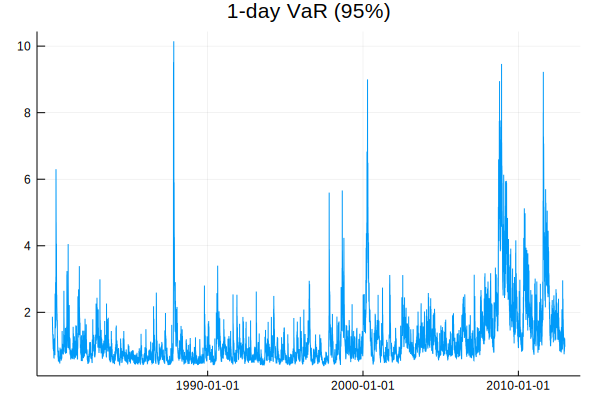

In [11]:
xTicks = [Date(1990);Date(2000);Date(2010)]     #controlling the tick locations

plot(dN[2:end],VaR95,xticks=Dates.value.(xTicks),legend=false)
title!("1-day VaR (95%)")